In [150]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [113]:
# we have very little data - of only 1300 people (900 in training set). 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Exploration

In [114]:

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [115]:
# The percent of people who survived, and basic distributional data
print("Survival Percent: ", np.mean(train_df["Survived"])*100)
noNan_tr = train_df.dropna()
train_df.describe()

print(noNan_tr.describe())

Survival Percent:  38.38383838383838
       PassengerId    Survived      Pclass         Age       SibSp  \
count   183.000000  183.000000  183.000000  183.000000  183.000000   
mean    455.366120    0.672131    1.191257   35.674426    0.464481   
std     247.052476    0.470725    0.515187   15.643866    0.644159   
min       2.000000    0.000000    1.000000    0.920000    0.000000   
25%     263.500000    0.000000    1.000000   24.000000    0.000000   
50%     457.000000    1.000000    1.000000   36.000000    0.000000   
75%     676.000000    1.000000    1.000000   47.500000    1.000000   
max     890.000000    1.000000    3.000000   80.000000    3.000000   

            Parch        Fare  
count  183.000000  183.000000  
mean     0.475410   78.682469  
std      0.754617   76.347843  
min      0.000000    0.000000  
25%      0.000000   29.700000  
50%      0.000000   57.000000  
75%      1.000000   90.000000  
max      4.000000  512.329200  


In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Thoughts:
From looking at the head we can make a number of observations:
1. Data imbalance - 38% of passengers survived and 62% did not - this imbalance should be taken into account.

2. Titles - we could try to get features from this column somehow. The names themselves are varied and probably not very informative, but people's titles may tell us something about them.

3. Missing values - Age and Cabin have missing values. Age can probably be imputed, but as most of Cabin's values are missing any values we try to impute will probably be off and only add bias to the model.

In [117]:
numericals = ["Age", "SibSp", "Parch", "Fare"]

def unique_counts(df, column_name, id_field, is_df=True):
  unique_vals = None
  if is_df:
    unique_vals = df[column_name].unique()
  
  counter = dict()
  for val in unique_vals:
    counter[val] = df[df[column_name] == val].count()[id_field]
  return counter

embarked_counts = unique_counts(train_df, "Embarked", "PassengerId")
pclass_counts = unique_counts(train_df, "Pclass", "PassengerId")
train_df["cabin_letters"] = train_df["Cabin"].apply(lambda c_str: 'E' if c_str is np.nan else c_str[0])

print("Embarked: ", embarked_counts)
print("Class: ", pclass_counts)
print("Cabin: ", Counter(train_df["cabin_letters"]))

Embarked:  {'S': 644, 'C': 168, 'Q': 77, nan: 0}
Class:  {3: 491, 1: 216, 2: 184}
Cabin:  Counter({'E': 719, 'C': 59, 'B': 47, 'D': 33, 'A': 15, 'F': 13, 'G': 4, 'T': 1})


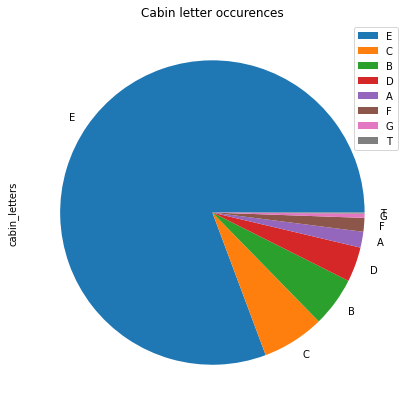

In [118]:
# We can see that most of the cabins are nulls. If the variables arent missing
# randomly, we could get good information about the non-null cabins.
fig, ax = plt.subplots()
train_df["cabin_letters"].value_counts().plot(kind='pie', title="Cabin letter occurences", 
                                              legend=True, rot=1, figsize=(7, 7)).legend(loc="upper right")

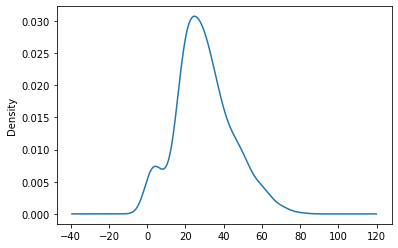

In [119]:
train_df["Age"].plot(kind="density") # It seems like the variance is relatively low - imputing the median seems like a good choice for now.

Still, lets check if the distribution in some other variables is affected by the presence of a nan in the age column:

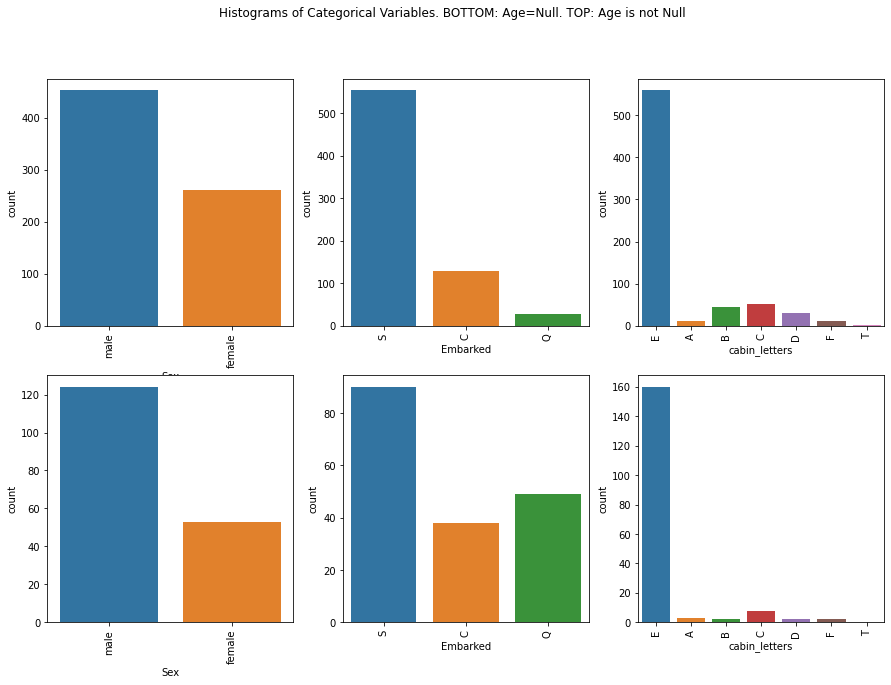

In [120]:
# Trying to graph relationships between Age and other values.
age_nans = np.isnan(train_df["Age"])


fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# yeah, this is weird. The list is doubled so that the indexes
# are plotted correctly
categorical = ["Sex", "Sex", "Embarked", "Embarked", "cabin_letters", "cabin_letters"]

# So plots can be compared
orders = {"Sex": ["male", "female"], "Embarked": ['S', 'C', 'Q'], 
          "cabin_letters": ['E', 'A', 'B', 'C', 'D', 'F', 'T']}

# Keeping track of the variables by index with counter
counter = 0
for variable, subplot in zip(categorical, ax.T.flatten()):
    
    # list of whether each row is a null or not
    nan_usage = age_nans  
    
    # the top row of the plot will not include nans
    if counter % 2 == 0:
      nan_usage = ~age_nans
    
    counter += 1
    sns.countplot(train_df[nan_usage][variable], ax=subplot, order=orders[variable])
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# assignment because fig.suptitle returns a value I dont want printed
dum_var = fig.suptitle("Histograms of Categorical Variables. BOTTOM: Age=Null. TOP: Age is not Null")

#### TODO: perform statistical test

we can see a difference between the two datasets. I want to check if it is
statistically significant. (with an alpha of lets say 0.1)

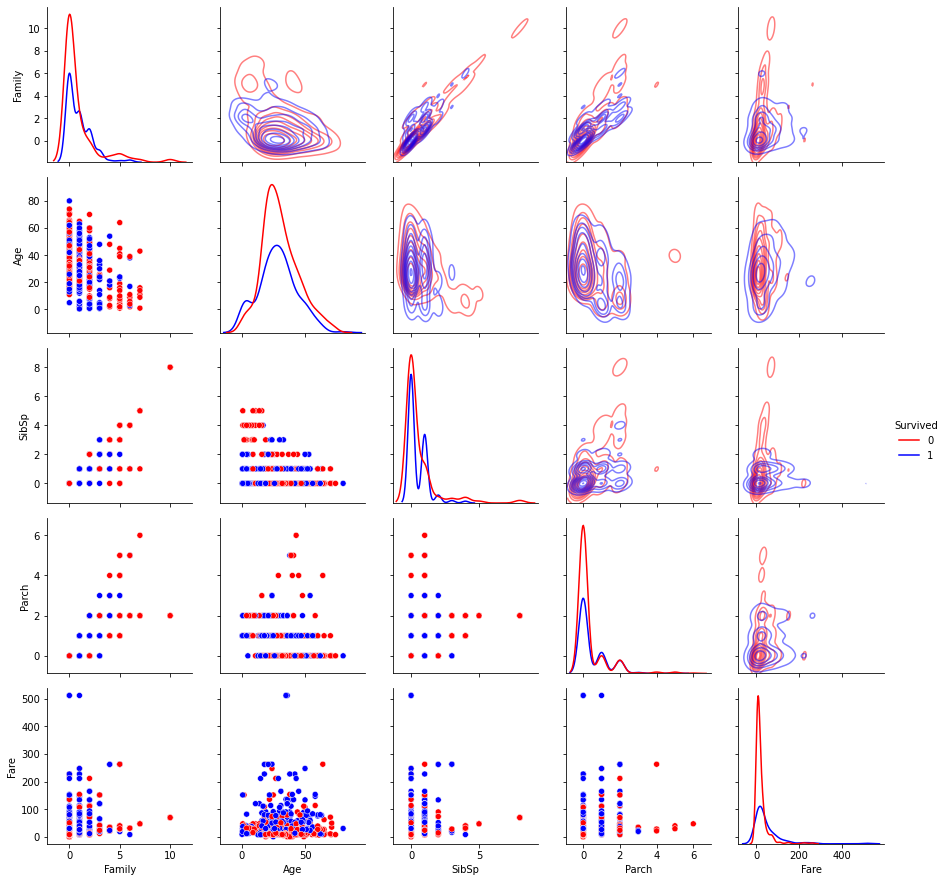

In [137]:
# visualizing numerical variables

d1 = train_df.copy()

# adding the family variable (Admittedly I got this off the internet)
d1["Family"] = d1["SibSp"] + d1["Parch"]

# plotting pair relations
g = sns.PairGrid(d1[["Survived", "Family"] + numericals], hue="Survived", palette={0:"red", 1:"blue"}, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, alpha=0.5)
g.add_legend()

## After looking at the variables:
Keeping in mind that there is a minority of survivors, among the single variables we can see that only sibsp and Fare have distributions that deviate significantly between those who survived and those who didn't.

Regarding the joint variables, We can see why adding Parch and sibsp together to create the family variable is on tutorials for feature engineering all over the net by looking at the parch-sibsp plot.


# Preprocessing and Training

In [122]:
def null_rows(df):
  return df[df.isnull().values == True] # rows with nan 

def preproc_general(df):
  data_df = df.copy()

  # creating new feature - 'cabin letter'
  data_df["cabin_letters"] = data_df["Cabin"].apply(lambda c_str: 'E' if c_str is np.nan else c_str[0])
  
  # dropping variables that arent useful (they are either unique or we extracted their value)
  data_df.drop(["Name", "Ticket", "Cabin"], axis=1)

  # imputing age, and Embarked
  data_df = data_df.fillna({"Embarked": "Unknown", "Age": data_df["Age"].median(), "Fare": data_df["Fare"].median()})
  
  # creating the family variable
  data_df["family"] = data_df["SibSp"] + data_df["Parch"]

  return data_df

def preprocess_log(df, dont_use=[]):
  data_df = preproc_general(df)
  use_cat = ["Sex", "Embarked", "cabin_letters"]
  
  # inefficiently removing columns we dont want to use
  for col in dont_use:
    use_cat.remove(col)

  # making dummy vars
  dummies = pd.get_dummies(["Sex", "Embarked", "cabin_letters"])
  data_df = pd.concat([data_df, dummies], axis=1)

  data_df = data_df.drop(columns=["Cabin", "Name", "PassengerId", "Ticket", "Sex", "Embarked", "cabin_letters"])
  
  if "Survived" in data_df.columns:
    return data_df.drop(columns="Survived"), data_df["Survived"]
  return data_df

def preprocess_rand_forest(df):
  return preprocess_log(df)

## Training and prediction

In [151]:
def print_eval(targets,predictions, train=True):
  if train:
    print("TRAINING EVAL:")
  else:
    print("TEST EVAL")
  
  print("Accuracy: ", accuracy_score(targets, predictions))
  print("Precision: ", precision_score(targets, predictions))
  print("Recall: ", recall_score(targets, predictions))
  print("F-Score: ", f1_score(targets, predictions))
  print("Roc-Auc: ", roc_auc_score(targets, predictions))

In [152]:
# Trying Logistic Regression on the data so far:

#splitting data
X, y = preprocess_log(train_df)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.17)

# Using cross validation and adding weights to help with the class imbalance
# note that as kaggle grades based on accuracy, it makes sense to give a little bit
# more weight to the majority classes than their proportion in the training set.
LogRegCV = LogisticRegressionCV(cv = 30, solver="lbfgs", max_iter=300, class_weight={0: 40, 1: 65})
LogRegCV.fit(X, y)
LogRegCV.get_params()

# cv = cross_val_score(LogRegCV, X, y, cv=100)
# LogRegCV.score(X, y)
# print("CV Score Logistic Regression: ", cv)
# print("CV mean: ", np.mean(cv))

log_pred = LogRegCV.predict(X)
print_eval(log_pred, y)

TRAINING EVAL:
Accuracy:  0.7194163860830527
Precision:  0.5380116959064327
Recall:  0.6666666666666666
F-Score:  0.5954692556634303
Roc-Auc:  0.7048780487804878


In [ ]:
prop_surv = 0.62/0.38  # inverse odds of survival (odds of death)
w = {{0:1, 1:prop_surv}, {0:1, 1:10}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:1.5}, {0:1, 1:1.1},
     {0:1, 1:1.2}, {0:1, 1:1.3}, {0:1, 1:2.5}}
param_grid = {"C": {0.25, 0.5, 1, 2, 4, 10, 20}, "class_weight": w}



### Trying to use a tree to predict errors.

In [124]:
from sklearn import preprocessing
# Lets try to predict the residuals with a random forest:
tree_res_data = X_train.copy()
# predict_proba gives 2 col df - col1 is P(y=0|xi), cal2 is P(y=1|xi). we take P(y=1|xi) (dont think it matters though)
tree_res_data["residual"] = np.abs(y - LogRegCV.predict_proba(X).T[1])

trained_tree, params, score = preproced_RF_grid_train(tree_res_data, y)
cv_res = cross_val_score(trained_tree, tree_res_data, y, cv=5)
print("Training Score: ", score)
print(cv_res)
print(params)

NameError: ignored

In [ ]:
predicted = trained_tree.fit(predict(test_df)
predicted

In [ ]:
# training a tree on preprocessed data.
def preproced_RF_grid_train(X, y):
  # grid search (note: I played with the grid search ahead of time - this is a demonstration)
  models = dict()
  criteria = ["gini", "entropy"]
  max_depths = [3, 7, 8, None]
  min_splits = [2, 5, 10]

  for crit in criteria:
    for depth in max_depths:
      for min_split in min_splits:
        tree = RandomForestClassifier(criterion=crit, max_depth=depth, min_samples_split=min_split)
        models[(depth, min_split, crit)] = np.mean(cross_val_score(tree, X, y, cv=2))

  best_params, score = max(models.items(), key=lambda x: x[1])
  best_tree = RandomForestClassifier(criterion=best_params[2], max_depth=best_params[0], 
                                   min_samples_split=best_params[1])
  return best_tree, best_params, score

In [ ]:
from heapq import heapify, heappush, heappop

# Trying Random Forest
X, y = preprocess_rand_forest(train_df)
forest_mod = RandomForestClassifier()

# grid search (note: I played with the grid search ahead of time - this is a demonstration)
models = dict()
criteria = ["gini", "entropy"]
max_depths = [3, 7, 8, None]
min_splits = [2, 5, 10]

for crit in criteria:
  for depth in max_depths:
    for min_split in min_splits:
      tree = RandomForestClassifier(criterion=crit, max_depth=depth, min_samples_split=min_split)
      models[(depth, min_split, crit)] = np.mean(cross_val_score(tree, X, y, cv=2))


best_params, score = max(models.items(), key=lambda x: x[1])
print("training score: ", score)
best_tree = RandomForestClassifier(criterion=best_params[2], max_depth=best_params[0], 
                                   min_samples_split=best_params[1])
cv =  cross_val_score(best_tree, X, y, cv=5)
print("best params: ", best_params)
print("CV Score Tree: ", cv)
print("mean: ", np.mean(cv))

In [ ]:
null_rows(X_test)

In [ ]:
X[X.isnull().values == True] # rows with nan 